In [2]:
import numpy as np
import igraph
from scipy import sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from bluepy import Circuit
import matplotlib.patches as mpatches
import tqdm
import pandas as pd
from bluepy import Circuit as bluepyCircuit
from pathlib import Path
import os


In [3]:
dpi=300
file_format = 'png'
fig_save_dir = f'{os.getcwd()}/output/'

In [2]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'

In [3]:
adj = sparse.load_npz(adj_path)
adj = adj[:adj.shape[1],:]

In [4]:
adj.mean()

0.003941157557997329

In [9]:
nz = adj.nonzero()

In [4]:
syns_per_conn = adj[adj>0]

In [ ]:
plt.hist(syns_per_conn, log=True)

In [ ]:
adj.nonzero()

In [4]:
adj.shape

(456378, 456378)

In [4]:
CIRCUIT_DIR = Path('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/')
bluepyc = bluepyCircuit((CIRCUIT_DIR / 'CircuitConfig').as_posix())

In [9]:
#PCPC degrees
target = 'Mosaic'
target_idx = np.intersect1d(c.cells.ids('SP_PC'),c.cells.ids(target))-1

In [10]:
target_idx.shape

(406666,)

In [11]:
target_indices_in_adj = np.where(np.isin(c.cells.ids(target)-1,target_idx))[0]

In [12]:
target_exc_to_all = adj[target_indices_in_adj,:]
target_exc_to_exc = target_exc_to_all[:,target_indices_in_adj]

In [10]:
target_exc_to_exc

<406666x406666 sparse matrix of type '<class 'numpy.float64'>'
	with 74379351 stored elements in Compressed Sparse Column format>

In [5]:
def density(adjacency):
    return adjacency.sum() / (adjacency.shape[0] * (adjacency.shape[0]-1))

In [14]:
density(adj)

0.0039411661937470525

In [13]:
density(target_exc_to_exc)

0.0005813590310402523

# average density of slices

In [6]:
targets = [i for i in bluepyc.cells.targets if i.startswith('slice') and not i.endswith('400um') ]

In [61]:
target_dict = {}

for i in tqdm.tqdm(targets):
    target_indices = c.cells.ids(i)-1 
    
    target_indices_EXC = np.intersect1d(c.cells.ids('SP_PC'),c.cells.ids(i))-1
    target_indices_in_adj = np.where(np.isin(c.cells.ids(i)-1,target_indices_EXC))[0]
    
    adj_slice_to_CA1 = adj[target_indices,:]
    adj_slice_to_slice = adj_slice_to_CA1[:,target_indices]
    
    adj_slice_exc_to_CA1 = adj[target_indices_in_adj,:]
    adj_slice_exc_to_exc = adj_slice_exc_to_CA1[:,target_indices_in_adj]
    
    target_dict[i] = {'all':density(adj_slice_to_slice),'EXC-EXC':density(adj_slice_exc_to_exc),
                      'num_cells':adj_slice_to_slice.shape[0],'num_EXC_cells':adj_slice_exc_to_exc.shape[0]}
    
df = pd.DataFrame.from_dict(target_dict).T

100%|██████████| 47/47 [01:33<00:00,  1.98s/it]


In [47]:
# Extract the numeric portion from the index names and convert to integers
numeric_indices = [int(idx[5:]) for idx in df.index]

# Sort the DataFrame based on the numeric indices
df_sorted = df.iloc[sorted(range(len(numeric_indices)), key=lambda k: numeric_indices[k])]

In [55]:
df_sorted.tail()

,all,EXC-EXC
slice42,0.207480,0.004246
slice43,0.245838,0.005168
slice44,0.308418,0.007210
slice45,0.530132,0.007060
slice46,5.555147,0.000000


In [5]:
out_path = 'data/density.csv'
import os
if not os.path.exists:
    df_sorted.to_csv('data/density.csv')
else:
    print('Already saved')

Already saved


In [7]:
out_path = '../../../data/density.csv'
df = pd.read_csv(out_path,index_col=0)

In [10]:
df.head()

,all,EXC-EXC
slice0,0.451379,0.006771
slice1,0.158104,0.003930
slice2,0.125417,0.003002
slice3,0.116212,0.003297
slice4,0.136666,0.003241


In [8]:
nodes_dict = {i:len(bluepyc.cells.ids(i)) for i in targets}
for mt,value in nodes_dict.items():
    df.loc[mt,'num_nodes'] = value

In [9]:
df = df[df.num_nodes >= 1000]

In [10]:
df.head()

,all,EXC-EXC,num_nodes
slice1,0.158104,0.003930,5425.0
slice2,0.125417,0.003002,7571.0
slice3,0.116212,0.003297,6703.0
slice4,0.136666,0.003241,6896.0
slice5,0.115869,0.002723,8541.0


/tmp/ipykernel_17965/948998515.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


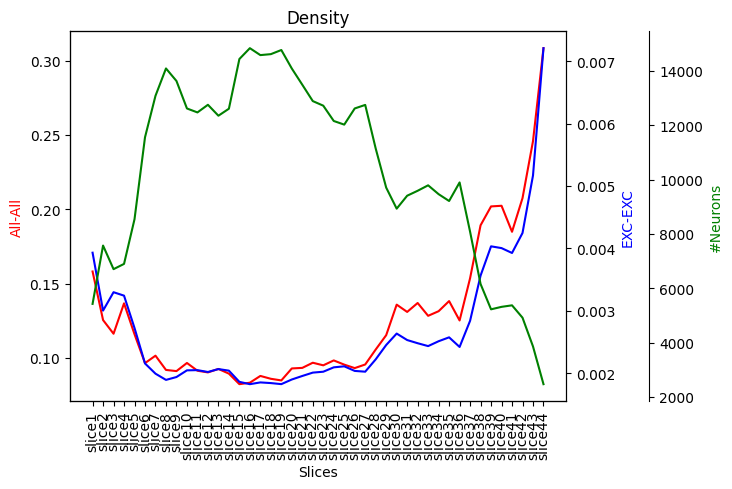

In [11]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot the first column on the primary y-axis
ax1.plot(df['all'], color='red')
ax1.set_ylabel('All-All', color='red')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second column on the secondary y-axis
ax2.plot(df['EXC-EXC'], color='blue')
ax2.set_ylabel('EXC-EXC', color='blue')

# Create a new axes object for the third plot
ax3 = ax1.twinx()

# Plot the third dataset on the new axes object
ax3.plot(df['num_nodes'], color='green', label='Plot 3')
ax3.set_ylabel('#Neurons', color='green')

# Adjust the spacing between the plots
ax2.spines['right'].set_position(('outward', 0))
ax3.spines['right'].set_position(('outward', 60))

# Set x-axis label
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1.set_xlabel('Slices')
plt.title('Density')
# Show the figure
plt.show()
# plt.savefig(f'{fig_save_dir}/density_DV.png',dpi=dpi, bbox_inches='tight')

In [16]:
save_dir = '../output/density'
os.makedirs(save_dir,exist_ok=True)

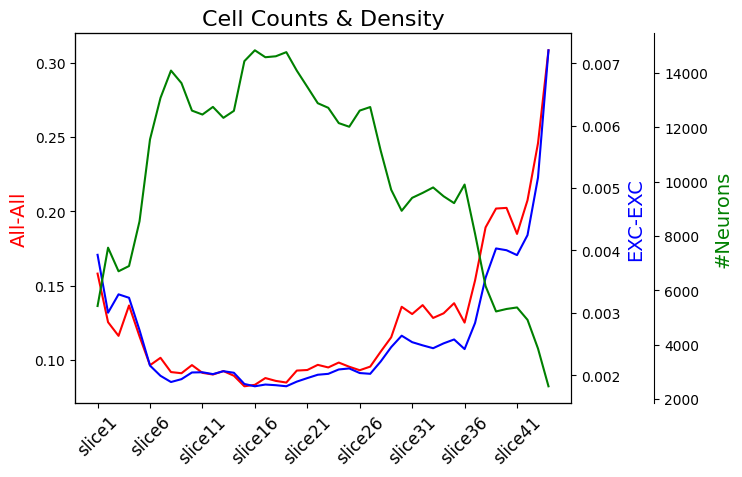

In [21]:
from tkinter import font
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot the first column on the primary y-axis
ax1.plot(df['all'], color='red')
ax1.set_ylabel('All-All', color='red',fontsize=14)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second column on the secondary y-axis
ax2.plot(df['EXC-EXC'], color='blue')
ax2.set_ylabel('EXC-EXC', color='blue',fontsize=14)

# Create a new axes object for the third plot
ax3 = ax1.twinx()

# Plot the third dataset on the new axes object
ax3.plot(df['num_nodes'], color='green', label='Plot 3')
ax3.set_ylabel('#Neurons', color='green',fontsize=14)

# Adjust the spacing between the plots
ax2.spines['right'].set_position(('outward', 0))
ax3.spines['right'].set_position(('outward', 60))

# Adjust xticks
xticks = ax1.get_xticks()
xtick_labels = ax1.get_xticklabels()
# for label in xtick_labels:
#     label.set_visible(False)
# for label in xtick_labels[::5]:
#     label.set_visible(True)
ax1.set_xticks(xticks[::5])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=12)

plt.title('Cell Counts & Density',fontsize=16)

# Show the figure
plt.savefig(f'{save_dir}/density_DV.pdf', dpi=dpi, bbox_inches='tight',format='pdf')
plt.show()


Fitted Equation: y = -547.03 * exp(0.00 * x) + 547.25
R-squared: 0.8141
P-values: [7.81970372e+10 2.20472823e-02 7.81970385e+10]
Confidence Intervals: [5.48089170e+05 2.91027215e-01 5.48089174e+05]
Linear Regression: y = 0.23 + -0.16 * x
Linear Regression R-squared: 0.8141
Linear Regression p-value: 0.0000
Standard Error of Regression: 0.0117


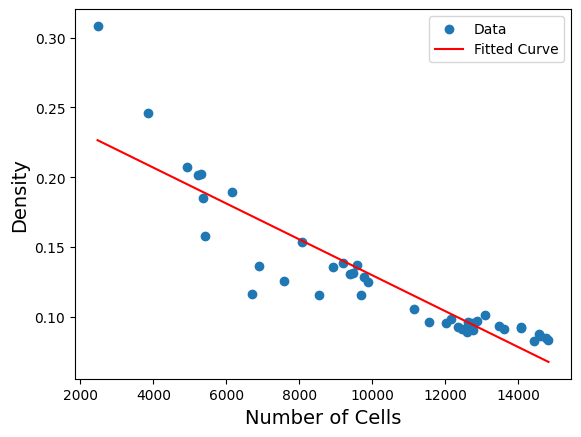

In [24]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Extract the data from the DataFrame
x = df['num_nodes'].values
y = df['all'].values

# Sort the x and y values together based on x
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Normalize the sorted x values using min-max scaling
x_normalized = (x_sorted - np.min(x_sorted)) / (np.max(x_sorted) - np.min(x_sorted))

# Define the equation to fit (replace with your desired equation)
def equation(x, a, b, c):
    return a * np.exp(b * x) + c

# Perform the curve fitting on the normalized x values
popt, pcov = curve_fit(equation, x_normalized, y_sorted,maxfev=10000)

# Retrieve the fitted parameters
a_fit, b_fit, c_fit = popt

# Generate the fitted curve using the original x range
x_fit = np.linspace(np.min(x), np.max(x), 100)
x_fit_sorted_normalized = (x_fit - np.min(x_sorted)) / (np.max(x_sorted) - np.min(x_sorted))
y_fit = equation(x_fit_sorted_normalized, a_fit, b_fit, c_fit)

# Calculate R-squared
residuals = y_sorted - equation(x_normalized, *popt)
ss_total = np.sum((y_sorted - np.mean(y_sorted))**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)

# Calculate p-values and confidence intervals
p_values = np.diag(pcov)
std_errors = np.sqrt(p_values)
conf_int = 1.96 * std_errors  # 95% confidence interval

# Perform linear regression on the normalized data
slope, intercept, r_value, p_value, std_err = linregress(x_normalized, y_sorted)

# Print the results
print(f"Fitted Equation: y = {a_fit:.2f} * exp({b_fit:.2f} * x) + {c_fit:.2f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-values: {p_values}")
print(f"Confidence Intervals: {conf_int}")
print(f"Linear Regression: y = {intercept:.2f} + {slope:.2f} * x")
print(f"Linear Regression R-squared: {r_value**2:.4f}")
print(f"Linear Regression p-value: {p_value:.4f}")
print(f"Standard Error of Regression: {std_err:.4f}")


# Plot the original data and fitted curve
plt.scatter(x_sorted, y_sorted, label='Data')
plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')
plt.xlabel('Number of Cells', fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.legend()

plt.savefig(f'{save_dir}/num_cells_vs_density.pdf',dpi=dpi, bbox_inches='tight',format='pdf')
plt.show()

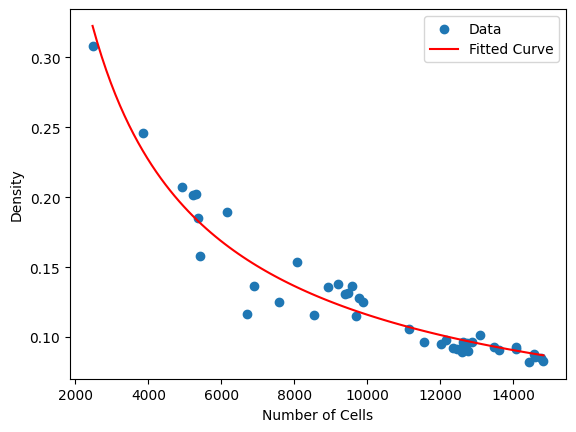

Fitted Equation: y = 97.74 * exp(-0.73 * x) + 0.28
R-squared: -inf
P-values: [4.65913129e+02 6.23883285e-04]
Confidence Intervals: [42.30664103  0.04895621]
Linear Regression: y = 0.23 + -0.16 * x
Linear Regression R-squared: 0.8141
Linear Regression p-value: 0.0000
Standard Error of Regression: 0.0117


/nvme/kurban/1578578/ipykernel_79193/4070656853.py:15: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b)


In [115]:
import numpy as np
from scipy.optimize import curve_fit

# Extract the data from the DataFrame
x = df['num_nodes'].values
y = df['all'].values

# Sort the x and y values together based on x
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Define the power-law equation to fit
def power_law_equation(x, a, b):
    return a * np.power(x, b)

# Perform the curve fitting
popt, pcov = curve_fit(power_law_equation, x_sorted, y_sorted)

# Retrieve the fitted parameters
a_fit, b_fit = popt

# Generate the fitted curve using the original x range
x_fit = np.linspace(np.min(x_sorted), np.max(x_sorted), 100)
y_fit = power_law_equation(x_fit, a_fit, b_fit)

# Plot the original data and fitted curve
plt.scatter(x_sorted, y_sorted, label='Data')
plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')
plt.xlabel('Number of Cells')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate R-squared
residuals = y_sorted - power_law_equation(x_normalized, *popt)
ss_total = np.sum((y_sorted - np.mean(y_sorted))**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)

# Calculate p-values and confidence intervals
p_values = np.diag(pcov)
std_errors = np.sqrt(p_values)
conf_int = 1.96 * std_errors  # 95% confidence interval

# Perform linear regression on the normalized data
slope, intercept, r_value, p_value, std_err = linregress(x_normalized, y_sorted)

# Print the results
print(f"Fitted Equation: y = {a_fit:.2f} * exp({b_fit:.2f} * x) + {c_fit:.2f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-values: {p_values}")
print(f"Confidence Intervals: {conf_int}")
print(f"Linear Regression: y = {intercept:.2f} + {slope:.2f} * x")
print(f"Linear Regression R-squared: {r_value**2:.4f}")
print(f"Linear Regression p-value: {p_value:.4f}")
print(f"Standard Error of Regression: {std_err:.4f}")


